In [ ]:
import numpy as np
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import os
import pandas as pd
import sys
sys.path.append('/Users/admin/Desktop/tesi/Thesis/')
import cv2
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
import sklearn.metrics as skmetrics
from sklearn.model_selection import GridSearchCV
from handcrafted_descriptors.grid_classification import utils
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt





def calculate_and_plot_precision_recall(tst_lab, pred, species, directory, string):
    precision, recall, fbeta, support = precision_recall_fscore_support(tst_lab, pred)
    
    df = pd.DataFrame({"X":species, "precision":precision,"recall":recall,'f1score': fbeta})
    df.plot(x="X", y=["precision", "recall",'f1score'], kind="bar")
    plt.tight_layout()
    plt.savefig(directory +'precision_recall_class4class'+string+'.jpg')
    return np.mean(precision), np.mean(recall), np.mean(fbeta)

def train_model_and_calculate_accuracy(train_features,train_lab,test_features,test_lab): 
    scaler = StandardScaler()
    scaler.fit(train_features)

    X_train = scaler.transform(train_features)
    X_test = scaler.transform(test_features)
    clc = []
    acc = []
    prec = []
    rec = []
    for i in range(1,51):
        classifier = KNeighborsClassifier(n_neighbors=i) 
        classifier.fit(X_train, train_lab)
        clc.append(classifier)
        y_pred = classifier.predict(X_test)
        acc_temp = 0
        total = y_pred.shape[0]
        for j in range(y_pred.shape[0]):
            if y_pred[j]==test_lab[j]:
                acc_temp = acc_temp + 1
        precision, recall, fbeta, support = precision_recall_fscore_support(test_lab, y_pred,zero_division=0)
        prec.append(np.mean(precision))
        rec.append(np.mean(recall))
        acc.append(acc_temp/total)
    return acc, prec, rec,clc 



In [2]:
# load matlab file, where gabor descriptor is saved
def load_descriptor_from_matfile(ft_path,lab_path):
    feat = loadmat(ft_path)
    feat = feat['dsc']
    lab = loadmat(lab_path)
    lab = lab['lab']
    return feat, lab

In [3]:
# functions to train models with best possible parameters

def search_for_best_rbf(training_feat, tr_lab, tst_features, tst_lab):
    param_grid = {'C': [ 1e0, 1e1, 1e2,1e3], 'gamma': [   0.01, 0.1,1]}
    clf0 = GridSearchCV(SVC(kernel='rbf'), param_grid)
    svc = clf0.fit(training_feat, tr_lab)
    print("Best estimator found by grid search : ", clf0.best_estimator_)
    y_pred = clf0.predict(tst_features)
    print('Accuracy score :', skmetrics.accuracy_score(y_pred, tst_lab))
    return clf0,skmetrics.accuracy_score(y_pred, tst_lab)

def search_for_best_poly(training_feat, tr_lab, tst_features, tst_lab):
    param_grid = {'degree':[2,3,4,5],'C': [ 1e0, 1e1, 1e2,1e3], 'gamma': [ 0.001, 0.01, 0.1,1]}
    clf0 = GridSearchCV(SVC(kernel='poly'), param_grid)
    svc = clf0.fit(training_feat, tr_lab)
    print("Best estimator found by grid search : ", clf0.best_estimator_)
    y_pred = clf0.predict(tst_features)
    print('Accuracy score :', skmetrics.accuracy_score(y_pred, tst_lab))
    return clf0, skmetrics.accuracy_score(y_pred, tst_lab)



In [4]:
# create confusion matrix and precision-recall plots 
def create_and_save_confusion_matrix(model, tst_features, tst_lab, species,director, name ):
    pred = model.predict(tst_features)
    df = utils.evaluated_prediction(pred, tst_lab, species)
    cm = utils.build_confusion_matrix(df, pred, tst_lab,species)
    utils.plot_confusion_matrix(cm,species,name,director,normalize=True,title='Confusion matrix')
    plt.close()
    return pred


def plot_and_save_knn(acc,prec,rec,direct):
    x1 = np.arange(1,51)
    plt.plot(x1, acc, label = "accuracy",color = 'r')
    plt.plot(x1,prec, label = 'precision')
    plt.plot(x1, rec, label = 'recall',color = 'g')
    plt.xlabel('number of neighbors')
    plt.ylabel('percentage (%)')
    plt.legend()
    plt.grid()
    plt.savefig(direct)
    plt.close()

In [5]:
species = ['Arthonia_radiata','Caloplaca_cerina','Candelariella_reflexa','Candelariella_xanthostigma','Chrysothrix_candelaris','Flavoparmelia_caperata','Gyalolechia_flavorubescens','Hyperphyscia_adglutinata'
        ,'Lecanora_argentata','Lecanora_chlarotera','Lecidella_elaeochroma','Melanelixia_glabratula'
        ,'Phaeophyscia_orbicularis','Physcia_biziana','Physconia_grisea','Ramalina_farinacea','Ramalina_fastigiata','Xanthomendoza_fallax','Xanthomendoza_fulva','flavoparmenia_soredians']


------------------
(1,1)
-------------------
start rbf
Best estimator found by grid search :  SVC(C=1000.0, gamma=1)
Accuracy score : 0.5233853006681515
------------------
(1,2)
-------------------
start rbf
Best estimator found by grid search :  SVC(C=1000.0, gamma=0.1)
Accuracy score : 0.5701559020044543
------------------
(1,3)
-------------------
start rbf
Best estimator found by grid search :  SVC(C=100.0, gamma=1)
Accuracy score : 0.6325167037861915
------------------
(1,4)
-------------------
start rbf
Best estimator found by grid search :  SVC(C=1000.0, gamma=0.1)
Accuracy score : 0.6681514476614699
------------------
(1,5)
-------------------
start rbf
Best estimator found by grid search :  SVC(C=1000.0, gamma=0.1)
Accuracy score : 0.6636971046770601
------------------
(1,6)
-------------------
start rbf
Best estimator found by grid search :  SVC(C=100.0, gamma=1)
Accuracy score : 0.6859688195991092
------------------
(1,7)
-------------------
start rbf
Best estimator found by

------------------
(7,6)
-------------------
start rbf
Best estimator found by grid search :  SVC(C=100.0, gamma=0.01)
Accuracy score : 0.8040089086859689
------------------
(7,7)
-------------------
start rbf
Best estimator found by grid search :  SVC(C=100.0, gamma=0.01)
Accuracy score : 0.8084632516703786
------------------
(7,8)
-------------------
start rbf
Best estimator found by grid search :  SVC(C=100.0, gamma=0.01)
Accuracy score : 0.799554565701559
------------------
(8,1)
-------------------
start rbf
Best estimator found by grid search :  SVC(C=1000.0, gamma=0.01)
Accuracy score : 0.7126948775055679
------------------
(8,2)
-------------------
start rbf
Best estimator found by grid search :  SVC(C=100.0, gamma=0.01)
Accuracy score : 0.7282850779510023
------------------
(8,3)
-------------------
start rbf
Best estimator found by grid search :  SVC(C=100.0, gamma=0.01)
Accuracy score : 0.8307349665924276
------------------
(8,4)
-------------------
start rbf
Best estimator 

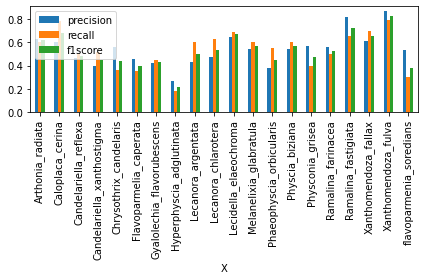

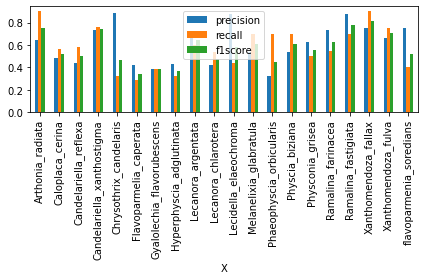

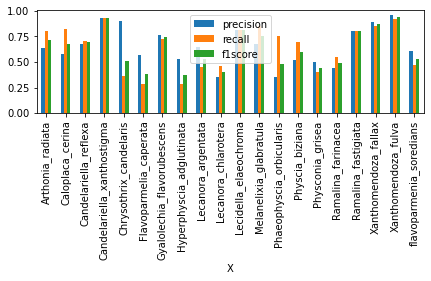

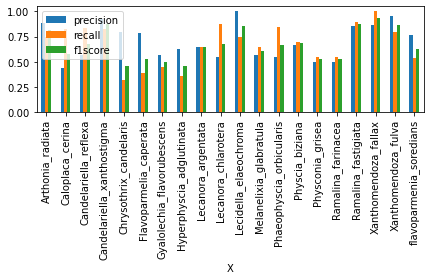

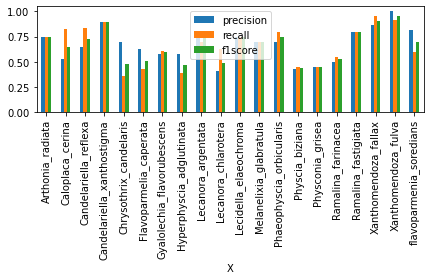

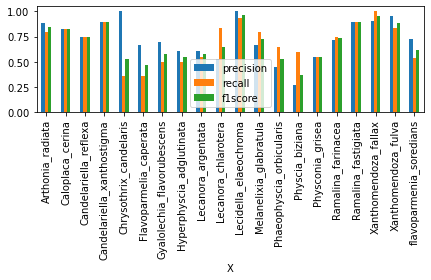

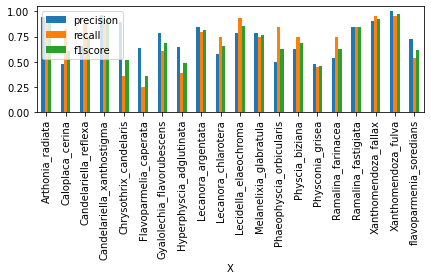

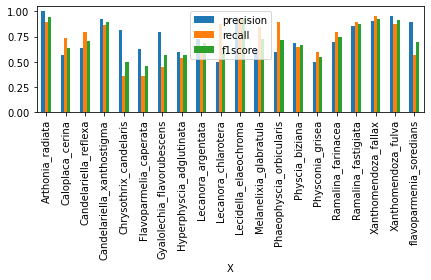

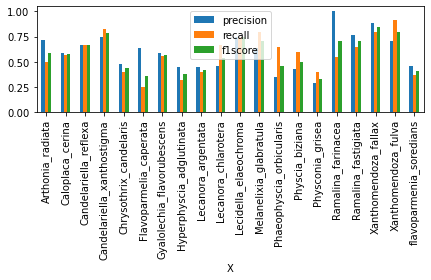

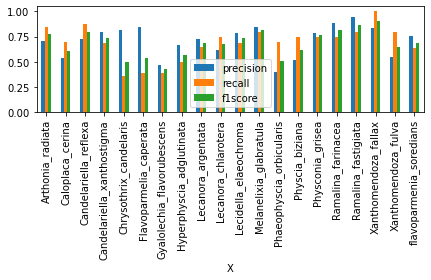

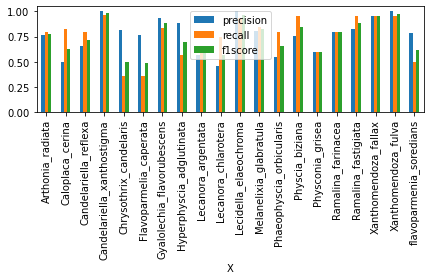

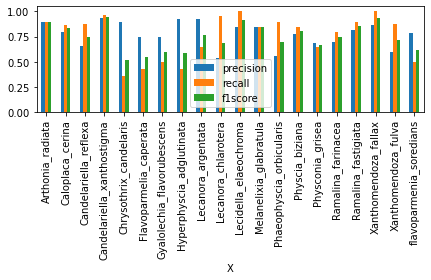

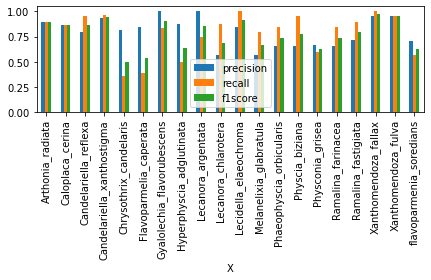

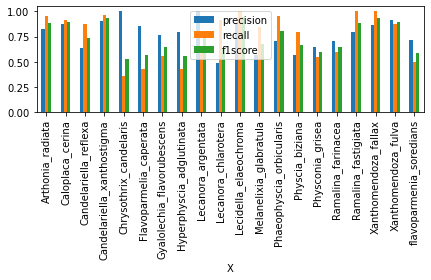

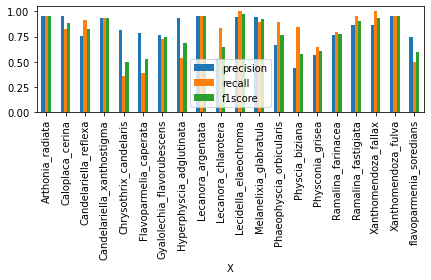

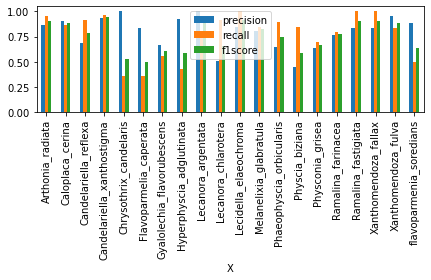

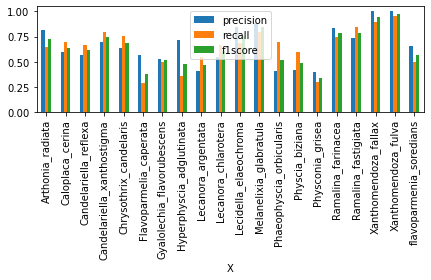

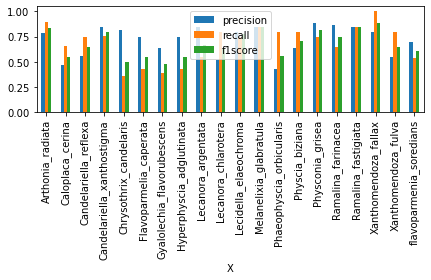

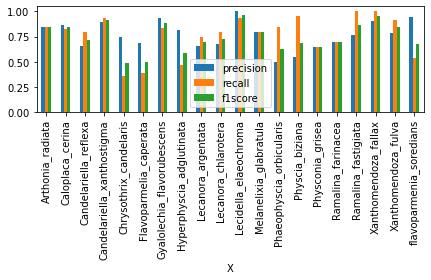

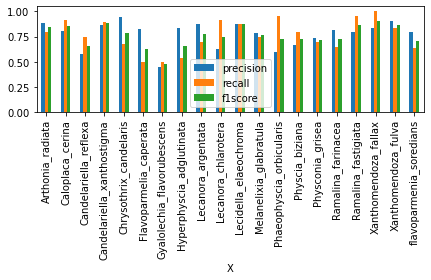

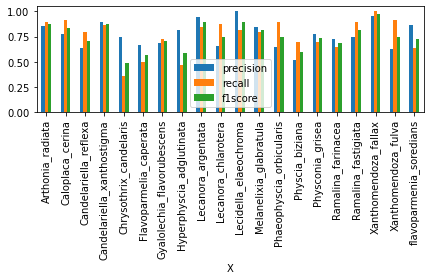

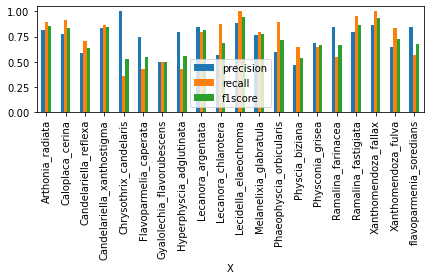

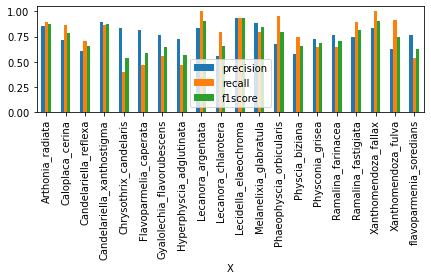

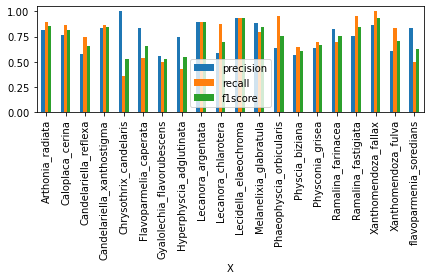

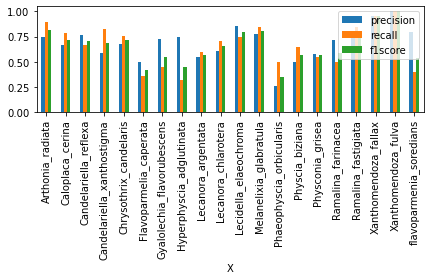

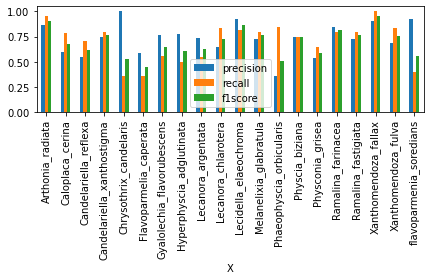

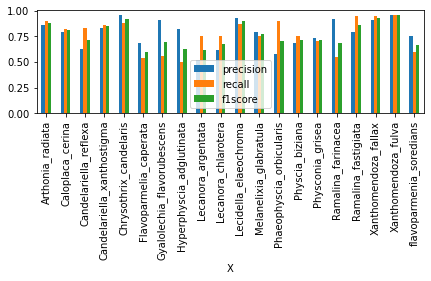

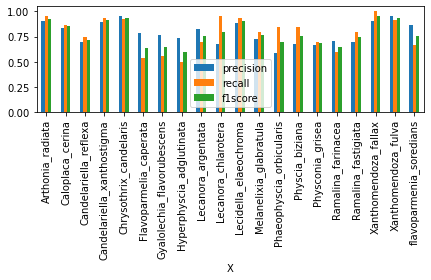

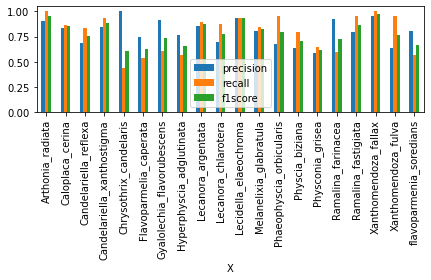

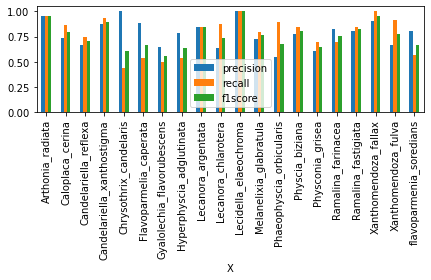

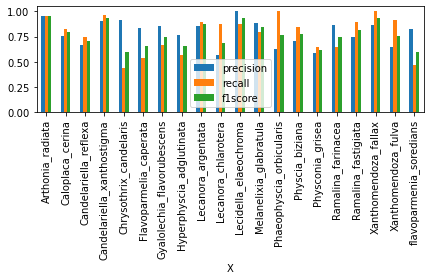

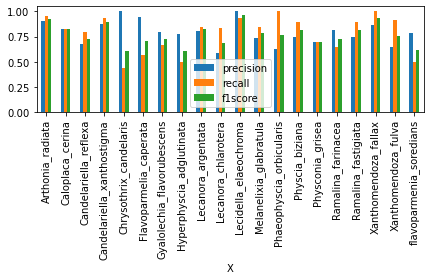

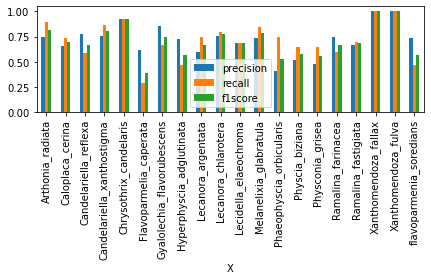

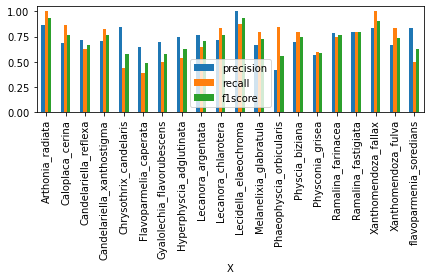

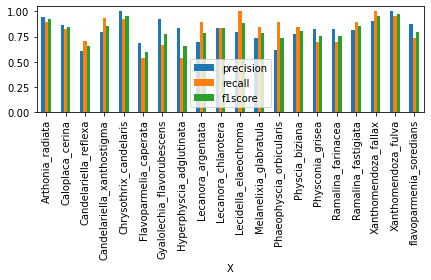

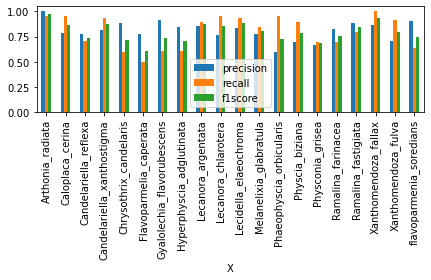

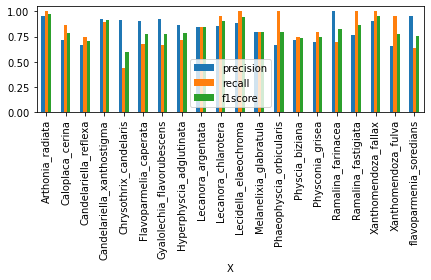

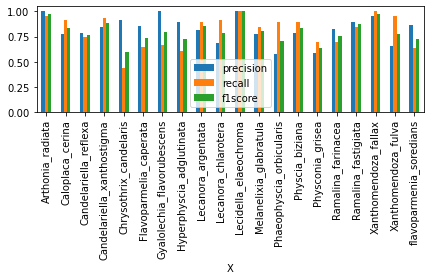

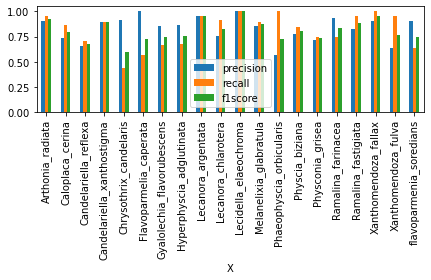

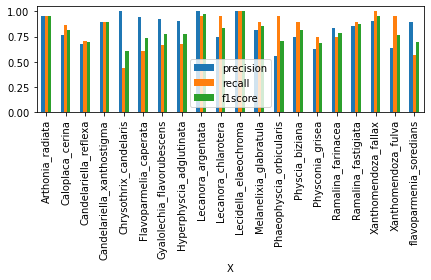

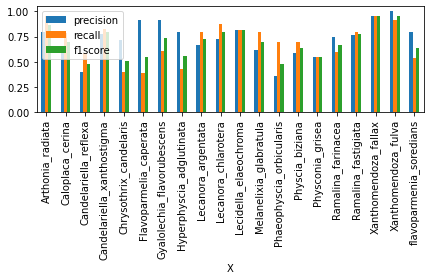

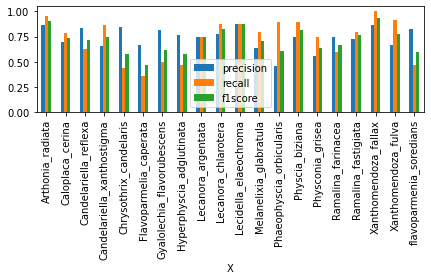

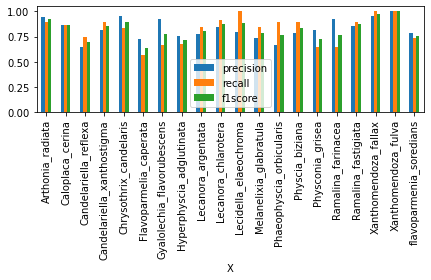

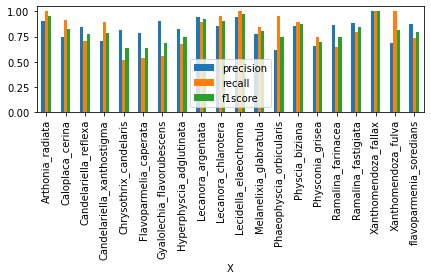

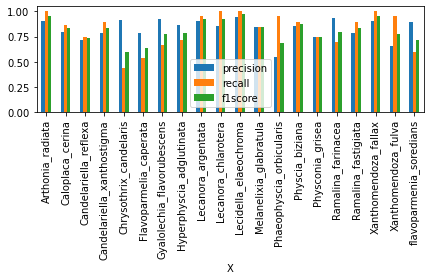

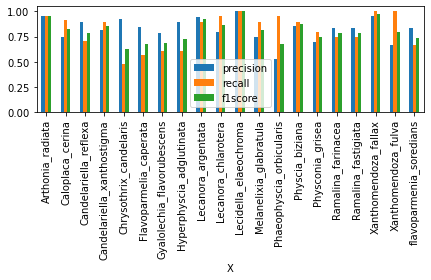

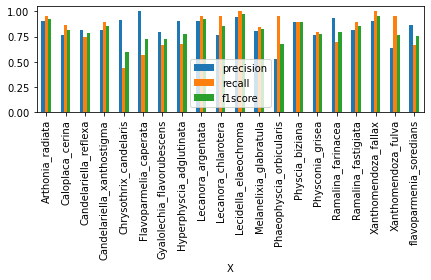

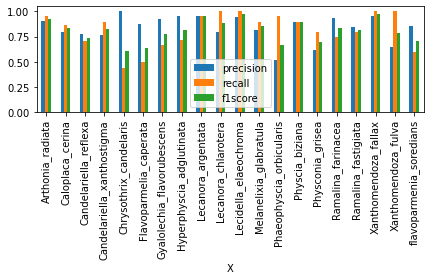

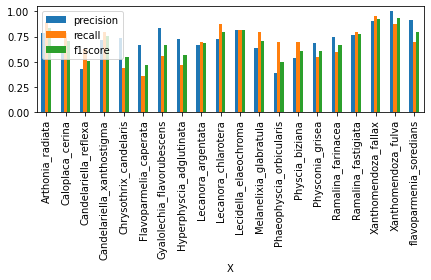

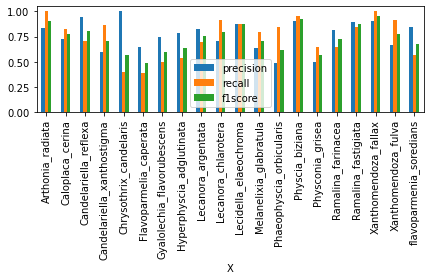

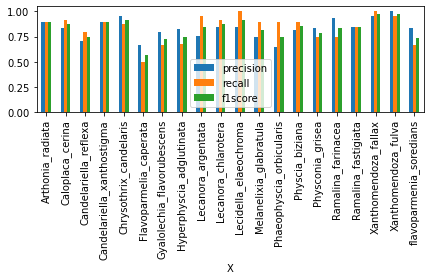

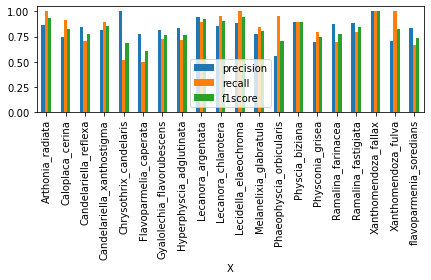

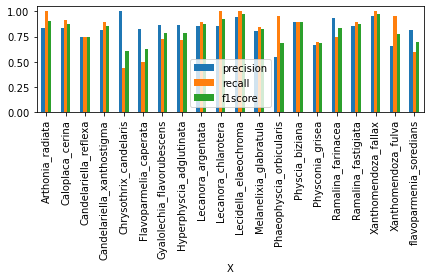

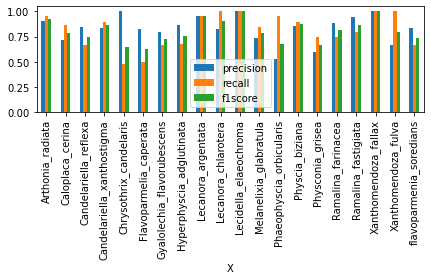

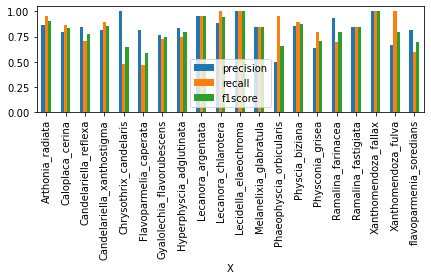

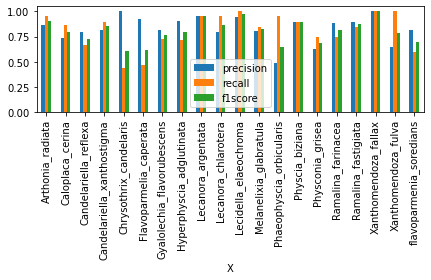

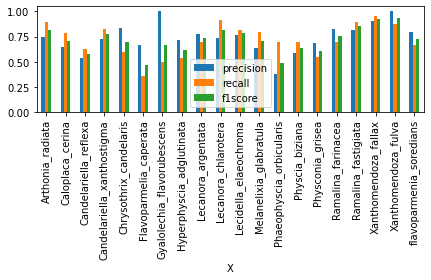

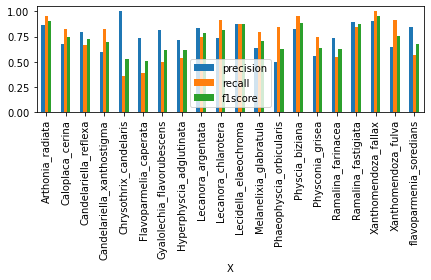

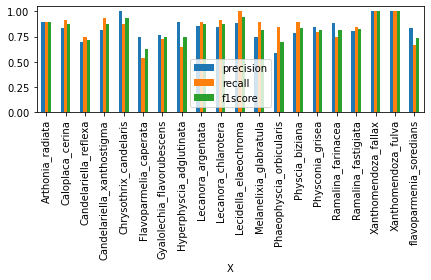

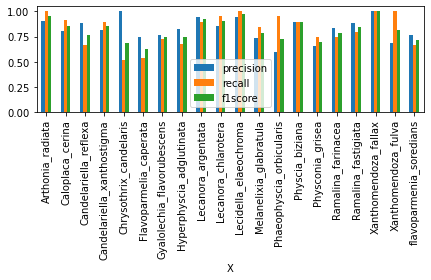

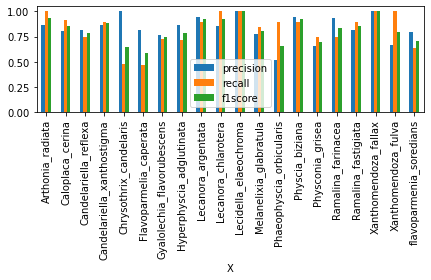

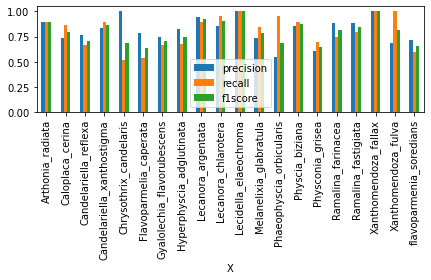

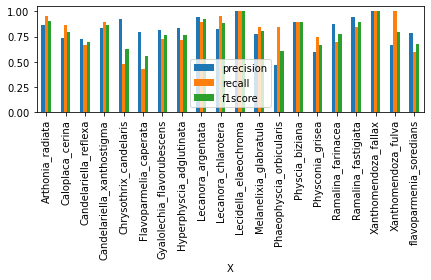

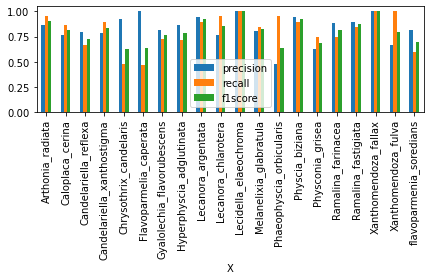

In [6]:
vector = ['1','2','3','4','5','6','7','8']


acc_radial = {}
acc_poly = {}
#acc_1nn = {}

for i,rot in enumerate(vector):
    for j,scale in enumerate(vector):
        print('------------------')
        print('(' + rot + ',' + scale + ')')
        print('-------------------')
        
        #create directories 
        director = 'results_gabor/confusion_matrix/'
        director_pra = 'results_gabor/pra/'
        name = 'cm_'+ rot + '_' + scale
        name_pra = 'pra_'+ rot + '_' + scale
        
        string_training = 'dsc/' + str(rot) + '_' + str(scale) + '_' + 'train_descriptors.mat'
        string_training_label = 'dsc/' + str(rot) + '_' + str(scale) + '_' + 'train_labels.mat'       
        string_testing = 'dsc/' + str(rot) + '_' + str(scale) + '_' + 'test_descriptors.mat'
        string_testing_label = 'dsc/' + str(rot) + '_' + str(scale) + '_' + 'test_labels.mat'
        
        training_feat,tr_lab = load_descriptor_from_matfile(string_training, string_training_label)
        tst_features, tst_lab = load_descriptor_from_matfile(string_testing,string_testing_label)
        tr_lab = tr_lab -1
        tst_lab = tst_lab -1 
        print('start rbf')
        svm ,score_rbf = search_for_best_rbf(training_feat, tr_lab.reshape(-1), tst_features, tst_lab)
        pred =create_and_save_confusion_matrix(svm, tst_features, tst_lab, species,director, name)
        calculate_and_plot_precision_recall(tst_lab, pred, species, director_pra, name_pra)
        # claculate precision and recall 
        #print('start poly')
        #svm ,score_poly = search_for_best_poly(training_feat, tr_lab.reshape(-1), tst_features, tst_lab)
        #print('start 1nn')
        #acc, prec, rec,clc  = train_model_and_calculate_accuracy(training_feat, tr_lab.reshape(-1), tst_features, tst_lab.reshape(-1))
        #plot_and_save_knn(acc,prec,rec,'knn_gabor')
        acc_radial['(' + str(rot) + ',' + str(scale) + ')'] = score_rbf
        #acc_poly['(' + str(rot) + ',' + str(scale) + ')'] = score_poly
        #acc_1nn['(' + str(rot) + ',' + str(scale) + ')'] = acc[0]
        